1. Diseñar un experimento donde se consideren al menos 5 umbrales (threshold).
2. Probar estadisticamente el impacto del umbran sobre la precisión y el recall.
3. ¿Existe un digito con mayor facilidad de clasificar?



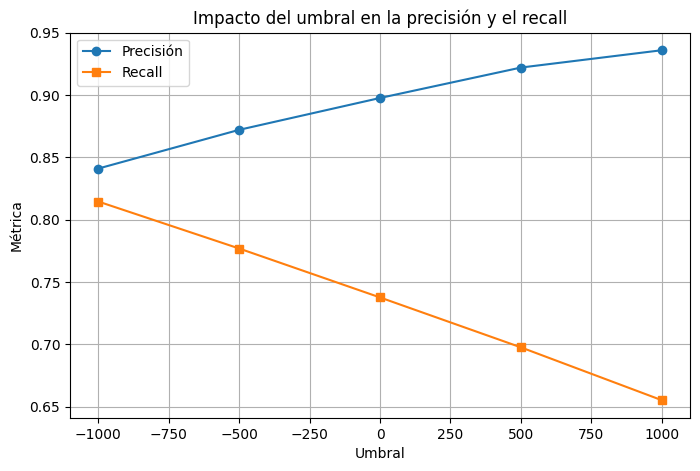

/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:4102: DegenerateDataWarning: all input arrays have length 1.  f_oneway requires that at least one input has length greater than 1.
  if _f_oneway_is_too_small(samples):


,Métrica,Estadístico,p-valor
0,Precisión (Umbrales),NaN,NaN
1,Recall (Umbrales),NaN,NaN
2,Precisión (Dígitos),9.0,0.437274
3,Recall (Dígitos),9.0,0.437274


In [3]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target.astype(np.uint8)

y_binary = (y == 5)

X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

clf = SGDClassifier(random_state=42)
clf.fit(X_train, y_train)

y_scores = clf.decision_function(X_test)


thresholds = [-1000, -500, 0, 500, 1000]
results = []

for threshold in thresholds:
    y_pred = (y_scores >= threshold)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results.append((threshold, precision, recall, f1))


results = np.array(results)

plt.figure(figsize=(8, 5))
plt.plot(results[:, 0], results[:, 1], marker='o', label="Precisión")
plt.plot(results[:, 0], results[:, 2], marker='s', label="Recall")
plt.xlabel("Umbral")
plt.ylabel("Métrica")
plt.title("Impacto del umbral en la precisión y el recall")
plt.legend()
plt.grid()
plt.show()

precision_per_digit = []
recall_per_digit = []

for digit in range(10):
    y_digit = (y_test == digit)
    precision_per_digit.append(precision_score(y_digit, y_pred, zero_division=0))
    recall_per_digit.append(recall_score(y_digit, y_pred, zero_division=0))

df_metrics = pd.DataFrame({
    "Dígito": range(10),
    "Precisión": precision_per_digit,
    "Recall": recall_per_digit
})


precision_values = results[:, 1]
recall_values = results[:, 2]

anova_precision = stats.f_oneway(*[results[results[:, 0] == t][:, 1] for t in thresholds])
anova_recall = stats.f_oneway(*[results[results[:, 0] == t][:, 2] for t in thresholds])

kruskal_precision = stats.kruskal(*[df_metrics[df_metrics["Dígito"] == d]["Precisión"] for d in range(10)])
kruskal_recall = stats.kruskal(*[df_metrics[df_metrics["Dígito"] == d]["Recall"] for d in range(10)])

stat_results = pd.DataFrame({
    "Métrica": ["Precisión (Umbrales)", "Recall (Umbrales)", "Precisión (Dígitos)", "Recall (Dígitos)"],
    "Estadístico": [anova_precision.statistic, anova_recall.statistic, kruskal_precision.statistic, kruskal_recall.statistic],
    "p-valor": [anova_precision.pvalue, anova_recall.pvalue, kruskal_precision.pvalue, kruskal_recall.pvalue]
})

from IPython.display import display
display(stat_results)